**CLASSIFICADOR DE ENQUADRAMENTO DE CARGOS DE PROFISSIONAIS**

**Descrição do problema**: Temos um conjunto de registros de enquadramentos de recursos humanos que representam diversos cargos na empresa. Cada cargo é representando por um código de material diferente. Cada material representa um valor em uma condição de preço, que será base para criação de um faturamento ao cliente. O objetivo deste notebook é criar um modelo de visão computacional que consiga classificar uma novo registro de enquadramento em algum código de material existente.

**Hipótese**: existem hipóteses em que dado um funcionário não é possível encontrar todos atributos de enquadramento (previsores) para seleção do material (target). Isso pode ocorrer por algum erro de cadastro do dado mestre do funcionário. Nessas sistuações, o sistema não gera um faturamento, havendo perda financeira para empresa. O objetivo é que o modelo consiga sempre classificar um conjunto de novos dados num material de faturamento mais próximo da realidade.

**Dataset**: O dataset é um exemplo real usando na classificacão de enquadramento de cargos. Não se trata de um dado sensível, uma vez que isoladamente não possui informação confidencial que possa causar prejuízo financeiro a empresa. Portanto, **não há restrição** para seleção dos dados.

Os atributos do dataset são:

1.  Mdt (Mandante Sistema) - representa o número do mandande do Sistema Integrado de Gestão
2.  Faixa SN (Faixa Salarial) - representa um código categórico de faixa salarial do funcionário
3.  Nv de (Nível salaria de) - representa um intervalo de nível salarial de-ate do funcionário
4.  Nv ate (Nível salaria ate) - representa um intervalo de nível salarial de-ate do funcionário
6.  Reg. Trabalho (Regime de Trabalho) - representa um código numérico do regime de trabalho do funcionário
7.  TpGr (Tipo de Garantia de Rendimento) - representa um código categórico do tipo de garantia de rendimento do funcionário
8.  Linha (Linha do Cargo) - representa um código numérico para agrupamento do cargo do funcionário
9.  Cargo (Cargo) - representa um código numérico do cargo do funcionário
Val. desde (Validade de) - representa a validade inicial do registro de enquadramento
10. Até (Validade até) - representa a validade final do registro de enquadramento
11. Material (Material) - representa o código do material de enquadramento - Target
12. Classificação (Classificação) - representa um código numérico para classidfificação do agrupamento do funcionário
13. Descrição da classificação (Descrição da classificação) - representa a descrição do cargo do funcionário
14. Criado por (Criado por) - representa o usuário que criou o registro de enquadramento
15. Dt.criação (Data de criação) - representa a data de criação do registro de enquadramento
16. Modificado por (Modificado por) - representa o usuário que modificou o registro de enquadramento
17. Dt.Modificação (Data de Modificação) - representa a data de modificação do registro de enquadramento



**Estrutura**: O notebook está dividido assim:

1.   Importação das bibliotecas
2.   Acesso aos dados que serão a entrada do modelo de classificação
3.   Pré-processamento dos dados
4.   Gerando algumas estatísticas dos dados
5.   Seleção de recursos (Feature Selection)
6.   Separando os dados em atributos previsores e target e tratando os dados categóricos
7. Aplicação do balanciamento dos dados
8. Separando em conjunto de Treino e Teste do modelo de classificação
10. Criação e avaliação do modelo - linha de base.
11. Criação e avaliação do modelo - dados patronizaçõs e normalizados.
12. Otimização de Hiperparâmetros
13. Avaliação do modelo com conjunto de testes
14. Simulando a aplicação do modelo em dados não vistos
15. Avaliação dos Resultados

1) **IMPORTAÇÃO DAS BIBLIOTECAS NECESSÁRIAS PARA EXECUTAR O NOTEBOOK**



In [1]:
import time
tempo_inicial = time.time()
tempo_total = 0

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")


# Imports necessários
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from PIL import Image
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.metrics import confusion_matrix # para a exibição da matrix de confusão
from sklearn.metrics import precision_score, recall_score # para a exibição da precisão e recall do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.linear_model import LogisticRegression # algoritmo de regressão logistica
from sklearn.svm import SVC # algoritmo SVM
from sklearn.pipeline import Pipeline
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest


tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')


 A CÉLULA NOTEBOOK DEMOROU 2 SEGUNDOS.


2) **ACESSO OS DADOS QUE SERÃO A ENTRADA DO MODELO DE DEEEP LEARNING**

In [2]:
tempo_inicial = time.time()
# Carga do dataset Enquadramento de Cargo
# url a importar do GITHUB
url_dados = 'https://github.com/igorbrasil1978/machine_learning_mvp/blob/main/enquadramento_hr.XLSX?raw=true'
ds_enquadra = pd.read_excel(url_dados)

ds_enquadra.info(verbose=True)
print(ds_enquadra.describe())

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')

ds_enquadra.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Mdt                         5905 non-null   int64         
 1   Faixa SN                    5905 non-null   object        
 2   Nv                          5905 non-null   int64         
 3   Nv.1                        5905 non-null   int64         
 4   Unnamed: 4                  3 non-null      float64       
 5   Reg. Trab.                  5905 non-null   int64         
 6   TpGR                        4600 non-null   object        
 7   Linha                       5905 non-null   int64         
 8   Cargo                       5905 non-null   int64         
 9   Vál.desde                   5905 non-null   datetime64[ns]
 10  até                         5905 non-null   object        
 11  Material                    5905 non-null   object      

,Mdt,Faixa SN,Nv,Nv.1,Unnamed: 4,Reg. Trab.,TpGR,Linha,Cargo,Vál.desde,até,Material,Classificação,Descrição da Classificação,Criado por,Dt.criação,Modif.por,Data mod.
0,400,NSA,1,99,NaN,12,9RC,9,0,2010-01-01,9999-12-31 00:00:00,50.000.117,16,COORDENADOR/GERENTE SOBREAVISO,Y1S5,2010-11-23,Y1S5,2010-11-23
1,400,MOFA,5,34,NaN,15,NaN,7,0,2016-01-01,9999-12-31 00:00:00,50.000.427,1,NÍVEL MÉDIO JUNIOR ADMINISTRATIVO,Z435,2016-01-14,Z435,2016-01-14
2,400,MOFA,5,34,NaN,17,NaN,7,0,2016-01-01,9999-12-31 00:00:00,50.000.427,1,NÍVEL MÉDIO JUNIOR ADMINISTRATIVO,Z435,2016-01-14,Z435,2016-01-14
3,400,MOFA,5,34,NaN,18,NaN,7,0,2016-01-01,9999-12-31 00:00:00,50.000.427,1,NÍVEL MÉDIO JUNIOR ADMINISTRATIVO,Z435,2016-01-14,Z435,2016-01-14
4,400,MOFA,5,34,NaN,19,NaN,7,0,2016-01-01,9999-12-31 00:00:00,50.000.427,1,NÍVEL MÉDIO JUNIOR ADMINISTRATIVO,Z435,2016-01-14,Z435,2016-01-14


**3) PRÉ-PROCESSAMENTO DOS DADOS ( ANALISTA DE NEGÓCIOS )**

Pré-processamento dos dados: em conversa com o Analista de Negócios da empresa foi passado que os atributos relevantes (atributos previsores) para classificação do enquadramento são:


1. Faixa SN (Faixa Salarial)
2. NV (Nível salarial de)
3. Nv.1 (Nível salarial até)
4. Reg.Trab. (Regime de trabalho)
5. TpGr (Tipo de garantia de rendimento)
6. Linha (Linha do cargo)
7. Cargo


A composição dessas features levam a classificação de um material que chamamos material de enquadramento (atributo target).

a) O Analista de Negócios explicou que são válidos os registros com valor 31.12.9999 no atributo até (Data Vigência Até).

b) O Analista de Negócios explicou que os atributos NV e NV.1 representam um intervalo de nível salarial de-até. Porém as novas entradas de dados é feita através de apenas um nível salarial. Serão criados grupos para representar cada intervalo.

c) As demais colunas do dataset são irrelavantes para o modelo.

d) O Analista de Negócio explicou que o campo TpGr não é obrigatório. Logo, em alguns registros são dados faltantes. Será representado por SEM (Sem tipo) os dados faltantes desse atributo, significando que não possui um tipo de gatantia de rendimento.



In [3]:
tempo_inicial = time.time()
# a) Selecionando apenas os dados com validade até 31.12.9999
data_str = '9999-12-31'
data_datetime = datetime.strptime(data_str, "%Y-%m-%d")
ds_enquadra = ds_enquadra[ds_enquadra['até'] == data_datetime ]

# b) Tranformando a coluna Nivel da-até em apenas uma coluna criando grupos para representar cada intervalo
ds_agrupamento_nivel = ds_enquadra[['Nv','Nv.1']]
agrupamento_nivel = ds_agrupamento_nivel.groupby(['Nv','Nv.1'])
agrupamento = 1
# recurso para criar um dataframe vazio com as mesmas colunas e tipos da original
ds_enquadra_nivel = ds_enquadra[ds_enquadra['Mdt'] == 100]
if not 'Med Nivel' in ds_enquadra.columns:
    ds_enquadra_nivel.insert(2, 'Med Nivel', 0)
for nivel, grupo in agrupamento_nivel:
  nivel_de = nivel[0]
  nivel_ate = nivel[1]
  ds_enquadra_aux = ds_enquadra[(ds_enquadra['Nv'] == nivel_de) & (ds_enquadra['Nv.1'] == nivel_ate)]
  if not 'Med Nivel' in ds_enquadra_aux.columns:
    ds_enquadra_aux.insert(2, 'Med Nivel', 0)
  ds_enquadra_aux['Med Nivel'] = agrupamento
  print(nivel, 'Grupo --> ', agrupamento)
  ds_enquadra_nivel = pd.concat([ds_enquadra_nivel, ds_enquadra_aux])
  agrupamento = agrupamento + 1

# c) dropando as colunas irrelevantes
# Quando alterei a leiura dos dados para o GITHUB o dataset veio com uma coluna diferente Unnamed: 4
ds_enquadramento = ds_enquadra_nivel.drop(columns=['Mdt', 'Nv', 'Nv.1', 'Unnamed: 4', 'Vál.desde','até','Classificação','Descrição da Classificação','Criado por','Dt.criação','Modif.por','Data mod.'])

# d) Preencher os dados faltantes da coluna TpGr com SEM (SEM tipo de garantia de rendimento)
print(ds_enquadramento.isna().sum()) #642 dados faltantes
values = {"TpGR": "SEM"}
ds_enquadramento = ds_enquadramento.fillna(value=values)

print(ds_enquadramento.shape)

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')

ds_enquadramento.head()

(1, 9) Grupo -->  1
(1, 11) Grupo -->  2
(1, 13) Grupo -->  3
(1, 22) Grupo -->  4
(1, 24) Grupo -->  5
(1, 27) Grupo -->  6
(1, 31) Grupo -->  7
(1, 51) Grupo -->  8
(1, 57) Grupo -->  9
(1, 62) Grupo -->  10
(1, 70) Grupo -->  11
(1, 99) Grupo -->  12
(5, 34) Grupo -->  13
(6, 10) Grupo -->  14
(9, 34) Grupo -->  15
(10, 24) Grupo -->  16
(11, 17) Grupo -->  17
(12, 24) Grupo -->  18
(18, 24) Grupo -->  19
(18, 34) Grupo -->  20
(19, 34) Grupo -->  21
(22, 34) Grupo -->  22
(23, 34) Grupo -->  23
(25, 32) Grupo -->  24
(25, 34) Grupo -->  25
(25, 50) Grupo -->  26
(28, 32) Grupo -->  27
(28, 52) Grupo -->  28
(33, 37) Grupo -->  29
(33, 51) Grupo -->  30
(34, 50) Grupo -->  31
(35, 36) Grupo -->  32
(37, 42) Grupo -->  33
(38, 42) Grupo -->  34
(39, 55) Grupo -->  35
(40, 43) Grupo -->  36
(41, 70) Grupo -->  37
(43, 52) Grupo -->  38
(44, 60) Grupo -->  39
(52, 52) Grupo -->  40
(52, 60) Grupo -->  41
(52, 70) Grupo -->  42
(53, 61) Grupo -->  43
(57, 65) Grupo -->  44
(58, 70) Grup

,Faixa SN,Med Nivel,Reg. Trab.,TpGR,Linha,Cargo,Material
3562,NSA,1,1,SEM,9,0,50.000.101
3564,NSA,1,3,SEM,9,0,50.001.037
3567,NSA,1,4,SEM,9,0,50.001.037
3569,NSA,1,5,SEM,9,0,50.001.037
3571,NSA,1,6,SEM,9,0,50.000.103


**4) GERANDO ESTATÍSTICAS DOS DADOS**

Gerando algumas estatísticas do dataset para análise dos dados.


 A CÉLULA NOTEBOOK DEMOROU 0 SEGUNDOS.


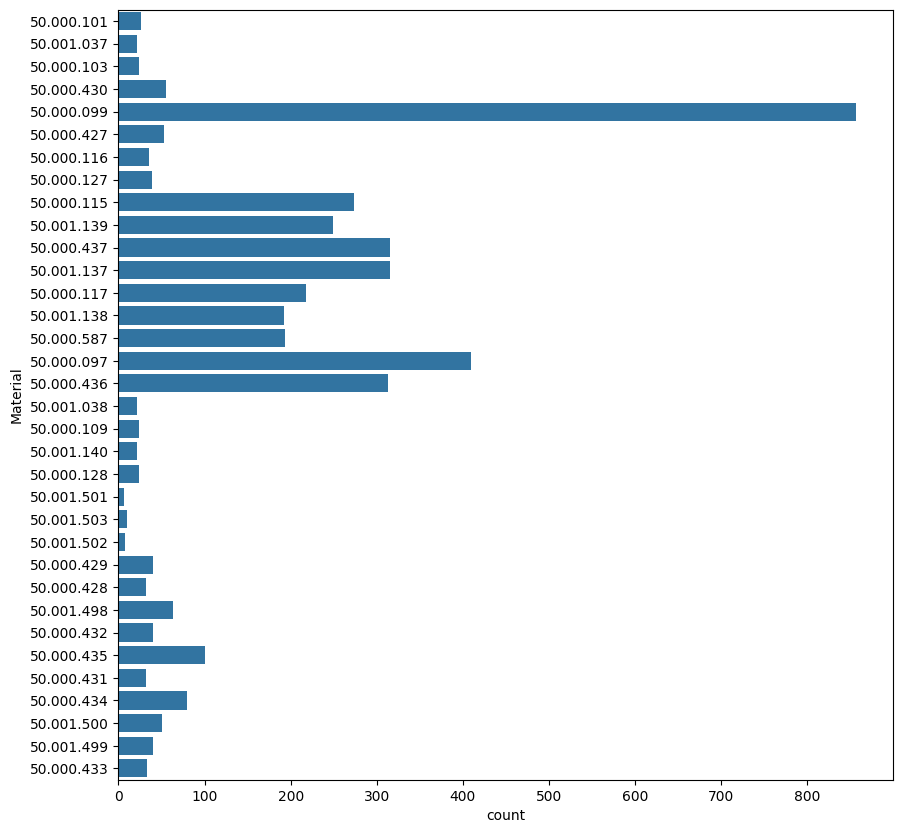

In [4]:
tempo_inicial = time.time()

#variável target Material desbalanciada
plt.subplots(figsize=(10,10))
sns.countplot(ds_enquadramento['Material'])

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')


 A CÉLULA NOTEBOOK DEMOROU 2 SEGUNDOS.


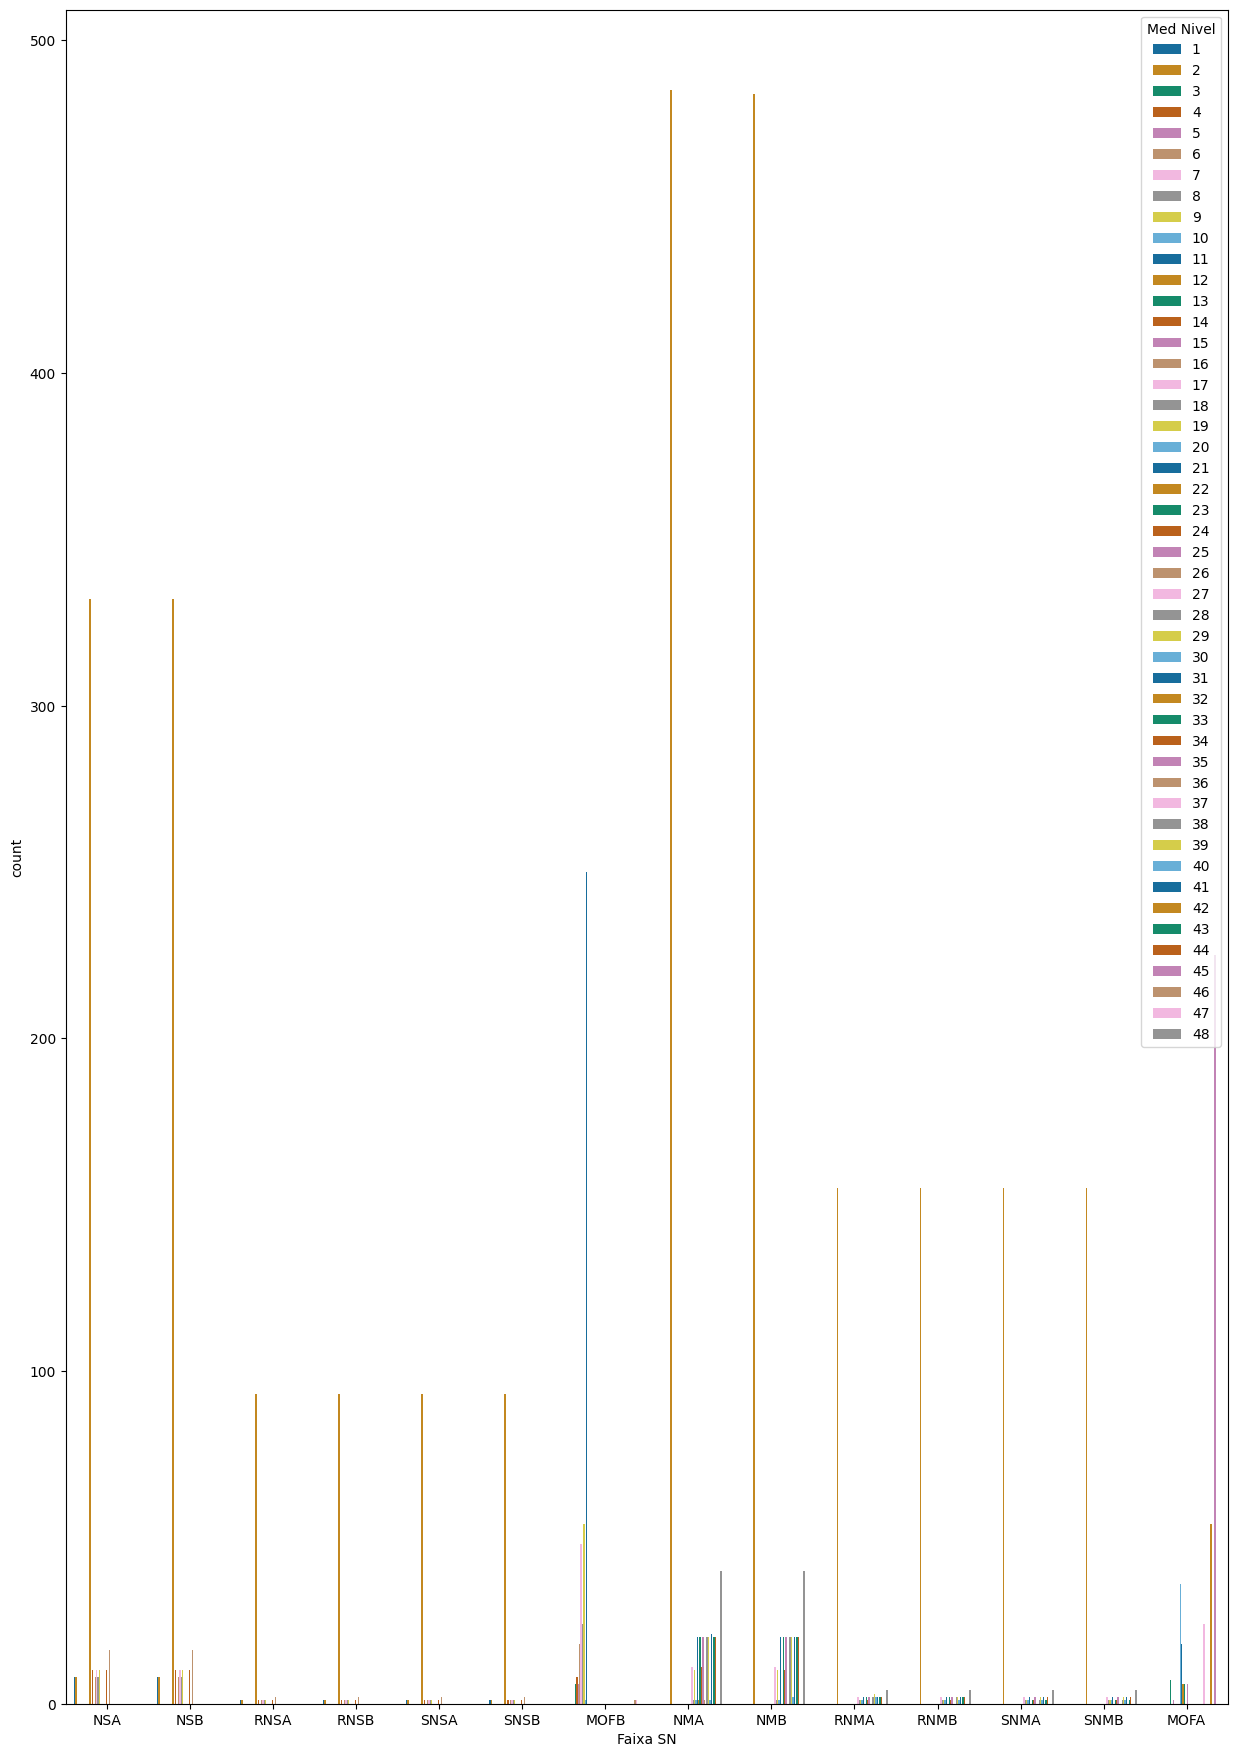

In [5]:
tempo_inicial = time.time()

plt.subplots(figsize=(15,22))
sns.countplot(x='Faixa SN', hue='Med Nivel', data=ds_enquadramento, palette='colorblind')

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')

In [6]:
tempo_inicial = time.time()
#Imprimindo os tipos de dados e valores categóricos
for coluna in ds_enquadramento.columns:
  if ds_enquadramento[coluna].dtype == 'object':
    print(str(coluna) + ' : ' + str(ds_enquadramento[coluna].unique()))
    print(ds_enquadramento[coluna].value_counts())

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')

Faixa SN : ['NSA' 'NSB' 'RNSA' 'RNSB' 'SNSA' 'SNSB' 'MOFB' 'NMA' 'NMB' 'RNMA' 'RNMB'
 'SNMA' 'SNMB' 'MOFA']
Faixa SN
NMA     723
NMB     719
NSA     420
NSB     420
MOFB    417
MOFA    383
RNMA    184
RNMB    182
SNMA    179
SNMB    179
RNSA    103
RNSB    103
SNSA    103
SNSB    103
Name: count, dtype: int64
TpGR : ['SEM' '9CCE' '9CCN' '9CCT' '9CT' '9GCE' '9RG' '9RB' '9RC' '9RM' '9CCS'
 '9GCM' '9FC' '9GS']
TpGR
SEM     642
9RC     593
9RM     593
9RB     592
9RG     577
9GS     237
9CCE    166
9CCN    166
9CCT    166
9CT     166
9GCE    118
9CCS     96
9GCM     96
9FC      10
Name: count, dtype: int64
Material : ['50.000.101' '50.001.037' '50.000.103' '50.000.430' '50.000.099'
 '50.000.427' '50.000.116' '50.000.127' '50.000.115' '50.001.139'
 '50.000.437' '50.001.137' '50.000.117' '50.001.138' '50.000.587'
 '50.000.097' '50.000.436' '50.001.038' '50.000.109' '50.001.140'
 '50.000.128' '50.001.501' '50.001.503' '50.001.502' '50.000.429'
 '50.000.428' '50.001.498' '50.000.432' '50.000.4

In [7]:
#Imprimindo a distribuição dos dados categóricos
ds_enquadramento.select_dtypes(include='object').describe()

,Faixa SN,TpGR,Material
count,4218,4218,4218
unique,14,14,34
top,NMA,SEM,50.000.099
freq,723,642,857


**5) SELEÇÃO DE RECURSOS BASEADOS EM MÉTODOS *ESTATÍSTICOS* (FEATURE SELECTION)**

Não houve refinamento de atributos através do FEATURE SELECTION. O Analista de Negócios já havia informado quais atributos previsores relavantes no pré-processamento, logo os atributos foram mantidos.

In [8]:
tempo_inicial = time.time()

#usando método que remove a variancia quando for menor que o parâmetro usado theshold
X_seletor = ds_enquadramento.iloc[:, 0:6]
y_seletor = ds_enquadramento.iloc[:,6]

#Transformação categorico em numérico
y_seletor = LabelEncoder().fit_transform(y_seletor)
X_seletor = X_seletor.values
X_seletor[:,0] = LabelEncoder().fit_transform(X_seletor[:,0])
X_seletor[:,3] = LabelEncoder().fit_transform(X_seletor[:,3])

seletor = VarianceThreshold(threshold=0.15)
seletor = seletor.fit(X_seletor)
seletor = seletor.transform(X_seletor)
print("Resultado Seleção de Recursos baseado em Variância: Não houve exclusão de features. \n") # Não houve exclusão de features
print(seletor)

#usando método mais relacionados ao TARGET (quanto maior a pontuação,mais a feature é relacionado ao TARGET)
X_seletor = ds_enquadramento.iloc[:, 0:6]
y_seletor = ds_enquadramento.iloc[:,6]

#Transformação categorico em numérico
y_seletor = LabelEncoder().fit_transform(y_seletor)
X_seletor = X_seletor.values
X_seletor[:,0] = LabelEncoder().fit_transform(X_seletor[:,0])
X_seletor[:,3] = LabelEncoder().fit_transform(X_seletor[:,3])

seletor = SelectKBest(k=3)
seletor.fit(X_seletor, y_seletor)
print("\n Resultado Seleção de Recursos baseado no Target: SCORES: k=3 \n")
print(seletor.scores_)
print(seletor.get_feature_names_out())

# Não usarei a técnica de separar o dataset em sub-datasets contando parte das features; SeleçãoFromModel e RFE (Recursive feature elimination)

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')


Resultado Seleção de Recursos baseado em Variância: Não houve exclusão de features. 

[[4 1 1 13 9 0]
 [4 1 3 13 9 0]
 [4 1 4 13 9 0]
 ...
 [11 48 27 13 16 0]
 [11 48 27 8 13 0]
 [11 48 27 8 16 0]]

 Resultado Seleção de Recursos baseado no Target: SCORES: k=3 

[ 19.30059161 130.46572821  17.53860877 102.86842688  32.07580048
 164.55891522]
['x1' 'x3' 'x5']

 A CÉLULA NOTEBOOK DEMOROU 0 SEGUNDOS.


**6) SEPARAÇÃO DO DATASET EM ATRIBUTOS PREVISORES E TARGET E TRANSFORMANDO DADOS CATEGÓRICOS**

In [9]:
tempo_inicial = time.time()

np.random.seed(7) # definindo uma semente global para este bloco

ds_enquadramento_previsor = ds_enquadramento.iloc[:, 0:6]
ds_enquadramento_target = ds_enquadramento.iloc[:,6]

#Transformação do target categorico em numérico
label_enconder_target = LabelEncoder()
ds_enquadramento_target = label_enconder_target.fit_transform(ds_enquadramento_target)
label_enconder_previsor_faixa = LabelEncoder()
label_enconder_previsor_tpgr = LabelEncoder()
ds_enquadramento_previsor = ds_enquadramento_previsor.values
ds_enquadramento_previsor[:,0] = label_enconder_previsor_faixa.fit_transform(ds_enquadramento_previsor[:,0])
ds_enquadramento_previsor[:,3] = label_enconder_previsor_tpgr.fit_transform(ds_enquadramento_previsor[:,3])

print(ds_enquadramento_previsor)
print(ds_enquadramento_target)

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')

[[4 1 1 13 9 0]
 [4 1 3 13 9 0]
 [4 1 4 13 9 0]
 ...
 [11 48 27 13 16 0]
 [11 48 27 8 13 0]
 [11 48 27 8 16 0]]
[ 2 22 22 ... 28 28 28]

 A CÉLULA NOTEBOOK DEMOROU 0 SEGUNDOS.


**7) APLICAÇÃO DO BALANCIAMENTO DOS DADOS**

Realizando o balanceamento da variável Target, uma vez que através da análise dos dados foi identificado um grande desbalanceamento entre o atributo alvo de maior incidência (maior 857) e menor incidência (menor 6).

**OBS**: Foi obeservado que com a técnica de balanceamento os modelos tornaram-se mais lentos, mas a acurácia melhorou.

In [10]:
tempo_inicial = time.time()

#criar o balanceador de dados - Oversampling
smote_bal = SMOTE(random_state=100)
ds_enquadramento_previsor, ds_enquadramento_target = smote_bal.fit_resample(ds_enquadramento_previsor, ds_enquadramento_target )

#variável target balanciada
print(pd.DataFrame(ds_enquadramento_target).groupby(0).size())

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')

0
0     857
1     857
2     857
3     857
4     857
5     857
6     857
7     857
8     857
9     857
10    857
11    857
12    857
13    857
14    857
15    857
16    857
17    857
18    857
19    857
20    857
21    857
22    857
23    857
24    857
25    857
26    857
27    857
28    857
29    857
30    857
31    857
32    857
33    857
dtype: int64

 A CÉLULA NOTEBOOK DEMOROU 0 SEGUNDOS.



 A CÉLULA NOTEBOOK DEMOROU 0 SEGUNDOS.


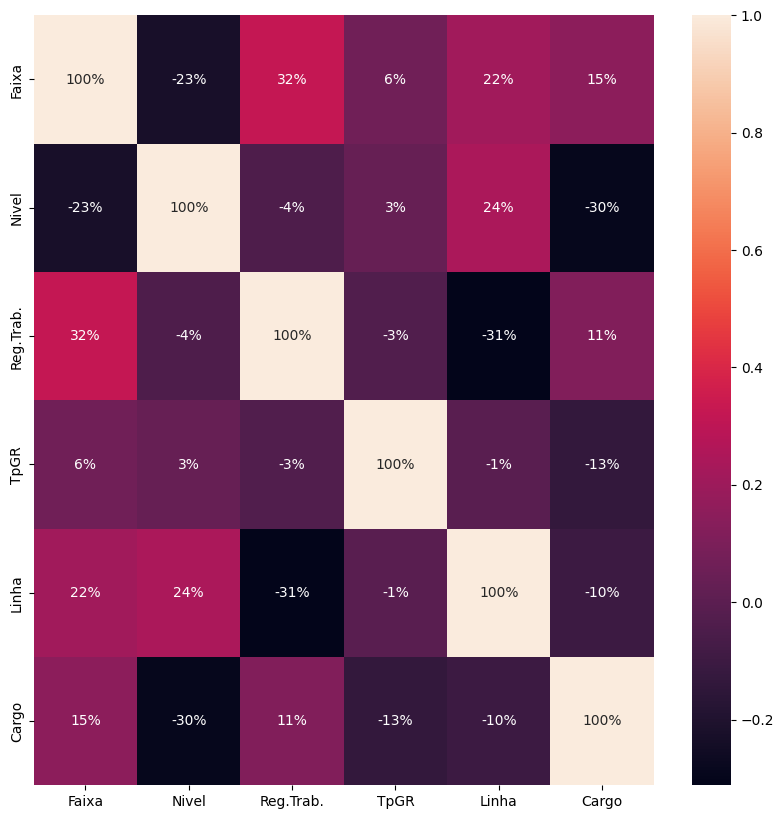

In [11]:
tempo_inicial = time.time()

#visualizando as correlações entre os atributos previsores
plt.subplots(figsize=(10,10))
ds_enquadramento_corr = pd.DataFrame(ds_enquadramento_previsor, columns=['Faixa','Nivel','Reg.Trab.','TpGR','Linha','Cargo'])
sns.heatmap(ds_enquadramento_corr.corr(), annot=True, fmt='.0%')

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')

**8) SEPARAÇÃO EM CONJUNTO DE TREINO E CONJUNTO DE TESTE**


In [12]:
tempo_inicial = time.time()
# holdout com estratificação
X_enquadramento_train, X_enquadramento_test, y_enquadramento_train, y_enquadramento_test = train_test_split(ds_enquadramento_previsor, ds_enquadramento_target, test_size=0.20, shuffle=True, random_state=7, stratify=ds_enquadramento_target)

print ('X Treino Enquadramento')
print (X_enquadramento_train)
print ('Y Treino Enquadramento')
print (y_enquadramento_train)
print ('\n')
print ('X Teste Enquadramento')
print (X_enquadramento_test)
print ('Y Teste Enquadramento')
print (y_enquadramento_test)

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')


X Treino Enquadramento
[[3.00000000e+00 4.80000000e+01 9.35424108e+00 1.30000000e+01
  1.30000000e+01 0.00000000e+00]
 [9.00000000e+00 1.20000000e+01 2.00000000e+00 1.15101928e+01
  1.00000000e+01 5.00009510e+07]
 [4.48066202e+00 1.40000000e+01 8.00000000e+00 1.30000000e+01
  1.50000000e+01 0.00000000e+00]
 ...
 [1.10000000e+01 1.20000000e+01 2.70000000e+01 1.00000000e+00
  1.10000000e+01 0.00000000e+00]
 [5.00000000e+00 1.60000000e+01 3.77061657e+00 1.30000000e+01
  9.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.30000000e+01 2.20268843e+01 1.30000000e+01
  7.00000000e+00 0.00000000e+00]]
Y Treino Enquadramento
[17 25  3 ...  1 23 10]


X Teste Enquadramento
[[ 2.75458868 12.         11.          9.24541132 14.          0.        ]
 [10.80727032 12.         27.         12.         13.          0.        ]
 [ 2.07116124 48.          7.21348371  8.         13.          0.        ]
 ...
 [ 2.48723538 43.          1.         13.         16.          0.        ]
 [ 4.         12.        

**9) CRIAÇÃO E AVALIAÇÃO DOS MODELOS: LINHA DE BASE (SEM TUNING HIPERPARÂMETROS)**

Vamos usar a validação cruzada para ter mais conhecimento do conjunto de dados, a fim de obter o melhor resultado, otimizando a separação dos dados de treino e teste. Vamos selecionar um kfold = 10.


In [13]:
tempo_inicial = time.time()

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7)
np.random.seed(7) # definindo uma semente global

# CRIAÇÃO DAS INSTÂNCIAS DOS MODELOS DE TREINO
class_regr_logistica = LogisticRegression()
class_arv_decicao = DecisionTreeClassifier()
class_knn = KNeighborsClassifier()
class_naive_bayes = GaussianNB()

clf_labels = [ 'LR', 'CART', 'KNN', 'NB','VOTING']
resultados = []
nomes = []

print('Validação cruzada: 10 partições:\n')

#criando os modelos para VotingClassifier
class_voting = ensemble.VotingClassifier(estimators=[('lr', class_regr_logistica), ('cart', class_arv_decicao), ('knn', class_knn), ('nb', class_naive_bayes)], voting='hard')
all_clf = [class_regr_logistica, class_arv_decicao, class_knn, class_naive_bayes, class_voting]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_enquadramento_train, y=y_enquadramento_train, cv=kfold, scoring=scoring)
    resultados.append(scores)
    nomes.append(clf)
    print("VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')


Validação cruzada: 10 partições:

VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.059 (+/- 0.007) [LR]
VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.925 (+/- 0.004) [CART]
VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.940 (+/- 0.004) [KNN]
VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.080 (+/- 0.011) [NB]
VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.878 (+/- 0.101) [VOTING]

 A CÉLULA NOTEBOOK DEMOROU 34 SEGUNDOS.


**10) CRIAÇÃO E AVALIAÇÃO DOS MODELOS: DADOS PADRONIZADOS E NORMALIZADOS (SEM TUNING HIPERPARÂMETROS)**



In [14]:
np.random.seed(7) # definindo uma semente global para este bloco

tempo_inicial = time.time()

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Algoritmos que serão utilizados
reg_log = ('LR',  class_regr_logistica)
cart = ('CART', class_arv_decicao)
knn = ('KNN', class_knn)
naive_bayes = ('NB', class_naive_bayes)
voting = ('Voting', class_voting)

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_enquadramento_train, y_enquadramento_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %0.3f (%0.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')

LR-orig: 0.059 (0.007)
CART-orig: 0.925 (0.004)
KNN-orig: 0.940 (0.004)
NB-orig: 0.080 (0.011)
Vot-orig: 0.878 (0.101)
LR-padr: 0.523 (0.010)
CART-padr: 0.933 (0.015)
KNN-padr: 0.833 (0.007)
NB-padr: 0.591 (0.007)
Vot-padr: 0.820 (0.007)
LR-norm: 0.490 (0.009)
CART-norm: 0.925 (0.004)
KNN-norm: 0.844 (0.007)
NB-norm: 0.592 (0.007)
Vot-norm: 0.817 (0.008)

 A CÉLULA NOTEBOOK DEMOROU 160 SEGUNDOS.


**11) OTIMIZAÇÃO DE HIPERPARÂMETROS (HP)**

Tuning usando GridSearch e RandonSearch (não vou usar o Bayesian Search - está em outro pacote).

Para efeito do Projeto, foi feito o Tuning do KNN e CART, obtendo melhores resultados usando um conjunto de hiperparâmetros.

"Tunar o HP é bom, mas o mais importante é o feature engineeiring."

In [15]:
tempo_inicial = time.time()
np.random.seed(7) # definindo uma semente global para este bloco

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines = []
knn = ('KNN', KNeighborsClassifier())
pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

#Hiperparâmetros do KNN
param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV (todos os parâmetros)
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_enquadramento_train, y_enquadramento_train)
    # imprime a melhor configuração
    treinos_knn = pd.DataFrame(grid.cv_results_)
    print("GridSearchCV: %s - Melhor: %0.2f usando %s, Número treinamento: %s " % (name, grid.best_score_, grid.best_params_, treinos_knn.shape[0]))

# Prepara e executa o RandonSearch (parâmetros randômicos)
for name, model in pipelines:
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=kfold, n_jobs = 8, n_iter = 10)
    grid.fit(X_enquadramento_train, y_enquadramento_train)
    # imprime a melhor configuração
    treinos_knn = pd.DataFrame(grid.cv_results_)
    print("RandonSearchCV: %s - Melhor: %0.2f usando %s, Número treinamento: %s " % (name, grid.best_score_, grid.best_params_, treinos_knn.shape[0]))

pipelines = []
cart = ('CART', DecisionTreeClassifier())
pipelines.append(('cart-orig', Pipeline(steps=[cart])))
pipelines.append(('cart-padr', Pipeline(steps=[standard_scaler, cart])))
pipelines.append(('cart-norm', Pipeline(steps=[min_max_scaler, cart])))

#Hiperparâmetros do CART
param_grid = {
     'CART__criterion': ["gini","entropy"],
     'CART__max_depth': [1,2,3,4,5,6,7,None]
}

# Prepara e executa o GridSearchCV (todos os parâmetros)
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, n_jobs=-1)
    grid.fit(X_enquadramento_train, y_enquadramento_train)
    # imprime a melhor configuração
    treinos_cart = pd.DataFrame(grid.cv_results_)
    print("GridSearchCV: %s - Melhor: %0.2f usando %s, Número treinamento: %s " % (name, grid.best_score_, grid.best_params_, treinos_cart.shape[0]))

#Prepara e executa o RandonSearch (parâmetros randômicos)
for name, model in pipelines:
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=kfold, n_jobs = 8, n_iter = 10)
    grid.fit(X_enquadramento_train, y_enquadramento_train)
    # imprime a melhor configuração
    treinos_knn = pd.DataFrame(grid.cv_results_)
    print("RandonSearchCV: %s - Melhor: %0.3f usando %s, Número treinamento: %s " % (name, grid.best_score_, grid.best_params_, treinos_knn.shape[0]))

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')


GridSearchCV: knn-orig - Melhor: 0.95 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 1}, Número treinamento: 33 
GridSearchCV: knn-padr - Melhor: 0.86 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}, Número treinamento: 33 
GridSearchCV: knn-norm - Melhor: 0.87 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}, Número treinamento: 33 
RandonSearchCV: knn-orig - Melhor: 0.95 usando {'KNN__n_neighbors': 3, 'KNN__metric': 'euclidean'}, Número treinamento: 10 
RandonSearchCV: knn-padr - Melhor: 0.85 usando {'KNN__n_neighbors': 9, 'KNN__metric': 'manhattan'}, Número treinamento: 10 
RandonSearchCV: knn-norm - Melhor: 0.87 usando {'KNN__n_neighbors': 9, 'KNN__metric': 'manhattan'}, Número treinamento: 10 
GridSearchCV: cart-orig - Melhor: 0.93 usando {'CART__criterion': 'entropy', 'CART__max_depth': None}, Número treinamento: 16 
GridSearchCV: cart-padr - Melhor: 0.93 usando {'CART__criterion': 'gini', 'CART__max_depth': None}, Número treinamento: 16 
GridSearchC

**12) AVALIAÇÃO DO MODELO COM O CONJUNTO DE TESTE**

In [16]:
# Avaliação do modelo com o conjunto de testes

tempo_inicial = time.time()
print('Avaliando Conjunto de testes:\n')

#usando os hiperparâmetros com melhor acurácia
class_knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
class_arv_decicao = DecisionTreeClassifier(criterion="entropy")

scaler = StandardScaler().fit(X_enquadramento_train) # ajuste do scaler com o conjunto de treino
escaledX = scaler.transform(X_enquadramento_train) # aplicação da padronização no conjunto de treino

for clf, label in zip([class_regr_logistica, class_arv_decicao, class_knn, class_naive_bayes], clf_labels):
    clf.fit(escaledX, y_enquadramento_train) # Criando um modelo com todo o conjunto de treino
    # Estimativa da acurácia no conjunto de teste
    rescaledTestX = scaler.transform(X_enquadramento_test) # aplicação da padronização no conjunto de teste
    predictions = clf.predict(rescaledTestX) # Fazendo as predições com o conjunto de teste
    print("AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: %0.3f " % (accuracy_score(y_enquadramento_test, predictions)), label) # Estimando a acurácia no conjunto de teste
    #matriz_confusao = confusion_matrix(y_enquadramento_test,predictions)
    #plt.figure(figsize=(20,10))
    #sns.heatmap(matriz_confusao, annot=True)

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')

Avaliando Conjunto de testes:

AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: 0.529  LR
AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: 0.927  CART
AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: 0.849  KNN
AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: 0.596  NB

 A CÉLULA NOTEBOOK DEMOROU 3 SEGUNDOS.


**13) SIMULAÇÃO DA APLICAÇÃO COM DADOS NÃO VISTOS - NÃO SABEMOS A CLASSE**

Simulei o resultado usando todos os modelos, apesar de saber que o KNN e CART obtiveram melhores resultados.

Otimizei os hiperparâmetros dos modelos KNN e CART.

In [17]:
tempo_inicial = time.time()

# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(ds_enquadramento_previsor) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(ds_enquadramento_previsor) # aplicação da padronização com TODO o dataset

class_naive_bayes.fit(rescaledX,ds_enquadramento_target)
class_regr_logistica.fit(rescaledX,ds_enquadramento_target)
class_knn.fit(rescaledX,ds_enquadramento_target)
class_arv_decicao.fit(rescaledX,ds_enquadramento_target)

#primeira Simulação
print ('PRIMEIRA SIMULAÇÃO:\n')
novos_dados = {'Faixa SN':  ['NMB','NSA','NSB','SNMB'],
        'Med Nivel': [12, 26, 16, 12],
        'Reg. Trab.': [6, 1, 1, 27],
        'TpGR': ['9RG', 'SEM','SEM', '9RB'],
        'Linha': [12, 9, 9, 14],
        'Cargo': [51174657, 0, 0, 51174657]
        }

atributos = ['Faixa SN', 'Med Nivel', 'Reg. Trab.', 'TpGR', 'Linha', 'Cargo']
ds_entrada = pd.DataFrame(novos_dados, columns=atributos)
array_entrada = ds_entrada.values

# Transformação dados categóricos
array_entrada[:,0] = label_enconder_previsor_faixa.transform(array_entrada[:,0])
array_entrada[:,3] = label_enconder_previsor_tpgr.transform(array_entrada[:,3])

#Escalonamento de dados
rescaledEntradaX = scaler.transform(array_entrada)

#previsão do modelo com novos dados
previsao_nb = class_naive_bayes.predict(rescaledEntradaX)
previsao_lr = class_regr_logistica.predict(rescaledEntradaX)
previsao_knn = class_knn.predict(rescaledEntradaX)
previsao_cart = class_arv_decicao.predict(rescaledEntradaX)

lista_decodificada_lr = label_enconder_target.inverse_transform(previsao_lr)
print('PREVISÃO Regressão Logística')
print(previsao_lr)
print(lista_decodificada_lr)
print('\n')

lista_decodificada_cart = label_enconder_target.inverse_transform(previsao_cart)
print('PREVISÃO CART')
print(previsao_cart)
print(lista_decodificada_cart)
print('\n')

lista_decodificada_knn = label_enconder_target.inverse_transform(previsao_knn)
print('PREVISÃO KNN')
print(previsao_knn)
print(lista_decodificada_knn)
print('\n')

lista_decodificada_nb = label_enconder_target.inverse_transform(previsao_nb)
print('PREVISÃO Naive Bayer')
print(previsao_nb)
print(lista_decodificada_nb)
print('\n')

# Novos dados - não sabemos a classe! Segunda simulação = Nível Empregado Cadastrado Indevidamente no Dado Mestre de Empregados - Sem relação direta no dataset original
# Somente com o modelo CART
print ('SEGUNDA SIMULAÇÃO:\n')

novos_dados2 = {'Faixa SN':  ['NMA','NMB','RNMA','SNMB'],
        'Med Nivel': [1, 2, 3, 4], #nível não correspondente ao dataset original - não há registros com a atual combinação
        'Reg. Trab.': [1, 6, 2, 27],
        'TpGR': ['9CT', '9RB','9RG', '9GCE'],
        'Linha': [11, 14, 14, 16],
        'Cargo': [0, 51614932, 52849273, 0]
        }

atributos2 = ['Faixa SN', 'Med Nivel', 'Reg. Trab.', 'TpGR', 'Linha', 'Cargo']
ds_entrada2 = pd.DataFrame(novos_dados2, columns=atributos2)
array_entrada2 = ds_entrada2.values

array_entrada2[:,0] = label_enconder_previsor_faixa.transform(array_entrada2[:,0])
array_entrada2[:,3] = label_enconder_previsor_tpgr.transform(array_entrada2[:,3])

rescaledEntradaX2 = scaler.transform(array_entrada2)
previsao_cart2 = class_arv_decicao.predict(rescaledEntradaX2)

lista_decodificada_cart2 = label_enconder_target.inverse_transform(previsao_cart2)
print('PREVISÃO CART')
print(previsao_cart2)
print(lista_decodificada_cart2)

tempo_final = time.time()
tempo_total = tempo_total + int(tempo_final - tempo_inicial)
print(f'\n A CÉLULA NOTEBOOK DEMOROU {int(tempo_final - tempo_inicial)} SEGUNDOS.')
print(f'\n TEMPO TOTAL APROXIMADAMENTE {int(tempo_total/60)} MINUTOS.')

PRIMEIRA SIMULAÇÃO:

PREVISÃO Regressão Logística
[19 27 23 25]
['50.000.436' '50.001.140' '50.001.038' '50.001.138']


PREVISÃO CART
[19  8  6 20]
['50.000.436' '50.000.127' '50.000.116' '50.000.437']


PREVISÃO KNN
[0 8 6 1]
['50.000.097' '50.000.127' '50.000.116' '50.000.099']


PREVISÃO Naive Bayer
[19 27 23 24]
['50.000.436' '50.001.140' '50.001.038' '50.001.137']


SEGUNDA SIMULAÇÃO:

PREVISÃO CART
[ 1  0 24  1]
['50.000.099' '50.000.097' '50.001.137' '50.000.099']

 A CÉLULA NOTEBOOK DEMOROU 3 SEGUNDOS.

 TEMPO TOTAL APROXIMADAMENTE 8 MINUTOS.


**14) AVALIAÇÃO DOS RESULTADOS:**

A simulação de novos dados foi feita com todos os modelos, a fim de comparar o resultado.

O modelo CART foi o modelo com melhor acurácia e de fato o resultado da primeira simulação representou 100% de acerto.

**PRIMEIRA SIMULAÇÃO**: numa primeira simulação com todos atributos previsores conhecidos, o modelo retornou os materiais (target) equivalente ao se fosse selecionar na base de dados original (filtro). Veja figura 1 na célula abaixo.

**SEGUNDA SIMULAÇÃO**: Numa segunda simulação, novos dados foram imputados (agora sem equivalencia total dos atributos) e o modelo classificou em um material (target). No filtro direto no dataset original não há correspondência, logo não traria nenhum material na função atual do Sistema Integrado de Gestão (target). Veja figura 2 na célula abaixo.

**CONCLUSÃO DO MUNDO REAL**: buscou-se aplicar o modelo de classificação de modo que o Sistema encontre o TARGET mais aproximado possível de um conjunto de features apresentados. Esse recurso vai possibilitar que SEMPRE seja realizado um faturamento, uma vez que o modelo sempre irá classificar em um material, requisito que atualmente não é obtido pelo atual Sistema Integrado de Gestão da Empresa. Entendo que alguns refinamentos no projeto podem ser realizados a fim de obter melhores resultados, algo que carece de maior tempo de projeto.


PRIMEIRA SIMULAÇÃO (Figura 1):



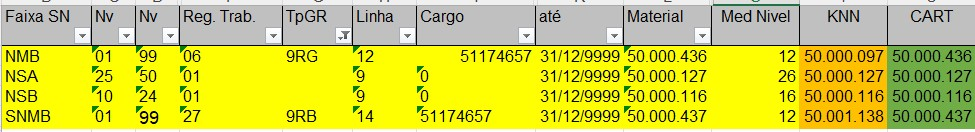

SEGUNDA SIMULAÇÃO (Figura 2):



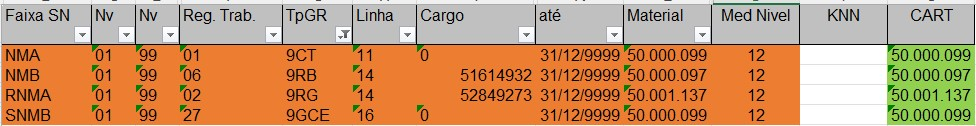

In [18]:

url = 'https://github.com/igorbrasil1978/machine_learning_mvp/blob/main/ds_enquadramento_novos_dados.jpg?raw=true'
filename = "ds_enquadramento_novos_dados.jpg"

url2 = 'https://github.com/igorbrasil1978/machine_learning_mvp/blob/main/ds_enquadramento_novos_dados_2.jpg?raw=true'
filename2 = "ds_enquadramento_novos_dados_2.jpg"

import urllib.request

urllib.request.urlretrieve(url, filename)
urllib.request.urlretrieve(url2, filename2)

try:
    print('PRIMEIRA SIMULAÇÃO (Figura 1):\n')
    img = Image.open(filename)
    display(img)
except OSError as e:
    print(f"Error opening image: {e}")

try:
    print('SEGUNDA SIMULAÇÃO (Figura 2):\n')
    img2 = Image.open(filename2)
    display(img2)
except OSError as e:
    print(f"Error opening image: {e}")